In [1]:
import numpy as np
import scipy.stats as stats
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.decomposition import NMF, LatentDirichletAllocation, FactorAnalysis, PCA
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix
import sys
sys.path.append('../data_science')
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns



np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
import pandas as pd

### Latent Variable Models

Assume that we have n students and k courses. All students have grades for all courses. Factor analysis assumes that actually there are few parameters (latent variables) which determine students' grades. For example IQ and study_time might be the basic factors which determine the grades. 

Let us assume that there are 5 courses. We will assume that IQ scores and study times of the students determine the grades they get from these courses. In other words we can model the grade of a student $s$ for course $c$ as follows:

$$
grade_{sc} = IQ_s*F_c + ST_s*F_c
$$

$F_c$ is the factor for each course which together with IQ and study time determine the grade. This is also reasonable to assume since otherwise a student would get the same grade from all courses.


In [80]:
n = 100
k = 5

# Students IQs normally distributed with mean = 100, std = 20
IQ = np.random.normal(100,20,n).reshape(n,-1)
ST = np.random.normal(10,2,n).reshape(n,-1)
IQST = np.hstack([IQ,ST])

# Course factors,  what do these values represent? why do we need them?
CF = np.random.rand(2,5)

print(CF)
print(IQST[:10])


[[0.93 0.21 0.57 0.31 0.55]
 [0.42 0.83 0.01 0.72 0.64]]
[[102.01  11.3 ]
 [ 99.92  10.44]
 [ 89.81   9.59]
 [ 88.69  12.35]
 [100.53  13.17]
 [102.9   10.57]
 [ 78.06   5.2 ]
 [ 59.1   12.1 ]
 [ 93.4   10.08]
 [105.97   7.54]]


In [70]:
GM = np.random.rand(100,5) * 100
GM

array([[23.35, 49.8 ,  1.74, 96.79, 76.84],
       [29.05, 11.97, 18.26, 12.25, 57.58],
       [45.12, 73.7 , 88.7 , 16.51, 41.5 ],
       [63.56, 79.08, 94.1 , 36.62, 53.09],
       [43.83, 85.55, 62.41, 33.96, 43.48],
       [75.04, 12.58, 46.88, 66.56, 32.64],
       [ 6.04, 52.98, 77.6 ,  7.1 ,  0.1 ],
       [98.28, 33.44, 61.31, 30.2 , 74.28],
       [49.29, 69.67, 29.67, 50.21, 23.84],
       [41.57, 86.46, 30.43, 46.48, 84.16],
       [46.62, 85.29, 67.7 , 64.07,  3.17],
       [23.69, 86.23, 46.97, 84.99, 66.59],
       [ 7.66, 47.75, 86.39, 85.83, 69.28],
       [67.16, 61.06, 79.13, 39.82, 17.68],
       [69.59, 57.37, 37.36, 93.68, 81.63],
       [19.23, 30.34, 76.35, 78.06, 39.68],
       [42.17, 53.05, 25.13, 27.9 , 15.72],
       [93.97, 38.87, 63.47, 28.72, 37.51],
       [94.7 , 92.81, 28.78, 35.93, 95.64],
       [71.16, 82.5 , 95.55, 17.08, 35.52],
       [93.58, 45.16, 33.7 , 41.12, 67.61],
       [ 5.86, 26.04, 31.75,  7.93, 15.76],
       [77.45, 27.06, 78.77, 10.

In [81]:
GM = np.dot(IQST,CF)
GM[:10]

array([[100.  ,  30.49,  58.43,  40.07,  63.13],
       [ 97.68,  29.34,  57.23,  38.79,  61.43],
       [ 87.88,  26.54,  51.44,  35.02,  55.35],
       [ 88.  ,  28.59,  50.82,  36.65,  56.5 ],
       [ 99.41,  31.73,  57.6 ,  40.95,  63.52],
       [100.51,  30.06,  58.93,  39.82,  63.15],
       [ 75.06,  20.48,  44.69,  28.19,  46.11],
       [ 60.28,  22.26,  33.89,  27.21,  40.12],
       [ 91.44,  27.69,  53.5 ,  36.49,  57.63],
       [102.1 ,  28.2 ,  60.67,  38.61,  62.9 ]])

In [34]:
GM.shape

(100, 5)

In [105]:
pd.DataFrame(GM).corr()

,0,1,2,3,4
0,1.000000,0.768615,0.723923,0.994148,0.840067
1,0.768615,1.000000,0.997743,0.695013,0.992721
2,0.723923,0.997743,1.000000,0.645163,0.982392
3,0.994148,0.695013,0.645163,1.000000,0.776549
4,0.840067,0.992721,0.982392,0.776549,1.000000


<Axes: >

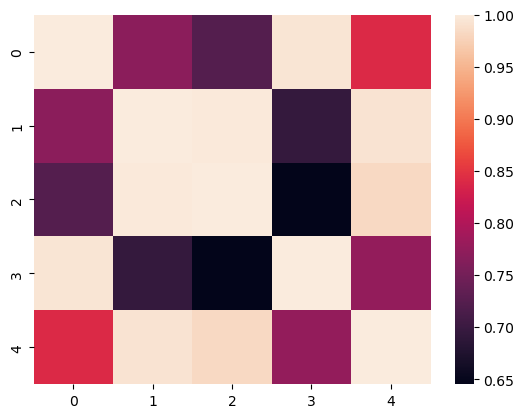

In [106]:
sns.heatmap(pd.DataFrame(GM).corr())

### Factor Analysis

In [8]:
fa = FactorAnalysis(n_components=2).fit(GM)

In [9]:
L = fa.components_
print(L)
F = fa.transform(GM)
print(F[:10])

[[-12.15  -6.07 -11.67  -5.55  -0.13]
 [ -0.27  -0.28   0.33   0.18   1.08]]
[[-0.74 -1.57]
 [-1.7  -1.98]
 [ 2.97 -0.21]
 [ 0.22 -1.33]
 [ 1.64  2.84]
 [-0.83  0.11]
 [ 1.86 -0.18]
 [ 0.42 -1.25]
 [-2.08  0.61]
 [ 0.11 -0.29]]


In [10]:
GM_recovered = fa.mean_ + np.dot(F,L)
GM_recovered[:10]

array([[77.97, 38.55, 76.62, 36.5 ,  3.88],
       [89.71, 44.47, 87.67, 41.74,  3.55],
       [32.51, 15.64, 33.74, 16.14,  4.87],
       [66.19, 32.63, 65.45, 31.19,  4.02],
       [47.85, 22.87, 50.3 , 24.09,  8.35],
       [78.65, 38.65, 78.28, 37.33,  5.71],
       [46.02, 22.39, 46.74, 22.33,  5.05],
       [63.74, 31.39, 63.14, 30.1 ,  4.08],
       [93.61, 46.05, 92.96, 44.32,  6.41],
       [67.29, 33.03, 67.12, 32.02,  5.16]])

In [11]:
GM[:10]

array([[77.97, 38.55, 76.62, 36.5 ,  3.88],
       [89.71, 44.47, 87.67, 41.74,  3.55],
       [32.51, 15.64, 33.74, 16.14,  4.87],
       [66.19, 32.63, 65.45, 31.19,  4.02],
       [47.85, 22.87, 50.3 , 24.09,  8.35],
       [78.65, 38.65, 78.28, 37.33,  5.71],
       [46.02, 22.39, 46.74, 22.33,  5.05],
       [63.74, 31.39, 63.14, 30.1 ,  4.08],
       [93.61, 46.05, 92.96, 44.32,  6.41],
       [67.29, 33.03, 67.12, 32.02,  5.16]])

### TruncatedSVD and Nonnegative Matrix Factorization

We can also do similar factorizations with TruncatedSVD or NMF.

In [111]:
from scipy.sparse import csr_matrix


# Create a dense matrix
dense_matrix = np.array([[0, 0, 0, 0],
                        [0, 5, 0, 0],
                        [0, 0, 0, 8]])

# Convert the dense matrix to a sparse matrix
sparse_matrix = csr_matrix(dense_matrix)

print(sparse_matrix)

  (1, 1)	5
  (2, 3)	8


In [13]:
from sklearn.decomposition import TruncatedSVD

In [14]:
tsvd = TruncatedSVD(n_components=2).fit(GM)
W = tsvd.transform(GM)
H = tsvd.components_
print(W[:10])
print(H)

[[121.56  -2.41]
 [139.48  -3.77]
 [ 52.13   2.57]
 [103.53  -1.25]
 [ 77.25   5.06]
 [123.42  -0.46]
 [ 72.98   1.6 ]
 [ 99.79  -0.98]
 [146.73  -0.97]
 [105.72  -0.09]]
[[ 0.64  0.31  0.64  0.3   0.05]
 [-0.26 -0.25  0.24  0.14  0.89]]


In [15]:
GM_recovered = np.dot(W,H)
GM_recovered[:10]

array([[77.97, 38.55, 76.62, 36.5 ,  3.88],
       [89.71, 44.47, 87.67, 41.74,  3.55],
       [32.51, 15.64, 33.74, 16.14,  4.87],
       [66.19, 32.63, 65.45, 31.19,  4.02],
       [47.85, 22.87, 50.3 , 24.09,  8.35],
       [78.65, 38.65, 78.28, 37.33,  5.71],
       [46.02, 22.39, 46.74, 22.33,  5.05],
       [63.74, 31.39, 63.14, 30.1 ,  4.08],
       [93.61, 46.05, 92.96, 44.32,  6.41],
       [67.29, 33.03, 67.12, 32.02,  5.16]])

In [115]:
GM[:10]

array([[ 15.08,  86.68,  83.83,  17.65,  45.74],
       [ 14.02,  97.07,  96.7 ,  16.05,  49.01],
       [ 13.99, 103.31, 103.83,  15.88,  51.44],
       [ 18.22, 129.98, 130.03,  20.78,  65.2 ],
       [ 14.59,  92.54,  90.99,  16.88,  47.67],
       [ 13.32,  94.68,  94.67,  15.19,  47.52],
       [ 15.53, 108.69, 108.44,  17.76,  54.75],
       [ 11.32,  83.6 ,  84.03,  12.84,  41.62],
       [ 12.98,  95.84,  96.32,  14.73,  47.72],
       [ 18.47, 126.66, 125.99,  21.17,  64.08]])

In [16]:
nmf = NMF(n_components=2).fit(GM)
W = nmf.transform(GM)
H = nmf.components_
print(W[:10])
print(H)

[[3.05 0.17]
 [3.39 0.24]
 [1.48 0.  ]
 [2.68 0.11]
 [2.2  0.  ]
 [3.31 0.08]
 [2.08 0.  ]
 [2.61 0.09]
 [3.89 0.12]
 [2.87 0.06]]
[[22.27 10.88 22.42 10.7   2.09]
 [54.75 26.96 54.26 25.87  3.56]]


/home/tevfik/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [17]:
GM_recovered = np.dot(W,H)
GM_recovered[:10]

array([[77.1 , 37.7 , 77.49, 36.98,  6.96],
       [88.48, 43.28, 88.89, 42.42,  7.92],
       [33.04, 16.14, 33.26, 15.88,  3.1 ],
       [65.64, 32.09, 66.  , 31.5 ,  5.98],
       [48.96, 23.92, 49.3 , 23.53,  4.59],
       [78.23, 38.24, 78.7 , 37.56,  7.2 ],
       [46.23, 22.59, 46.55, 22.22,  4.33],
       [63.26, 30.93, 63.62, 30.36,  5.78],
       [93.01, 45.47, 93.56, 44.65,  8.53],
       [67.  , 32.75, 67.41, 32.18,  6.19]])

In [20]:
GM[:10]

array([[  nan, 38.55, 76.62, 36.5 ,  3.88],
       [89.71, 44.47, 87.67, 41.74,  3.55],
       [32.51, 15.64, 33.74, 16.14,  4.87],
       [66.19, 32.63, 65.45, 31.19,  4.02],
       [47.85, 22.87, 50.3 , 24.09,  8.35],
       [78.65, 38.65, 78.28, 37.33,  5.71],
       [46.02, 22.39, 46.74, 22.33,  5.05],
       [63.74, 31.39, 63.14, 30.1 ,  4.08],
       [93.61, 46.05, 92.96, 44.32,  6.41],
       [67.29, 33.03, 67.12, 32.02,  5.16]])

# Missing Value
Suppose that one of the values in the GM matrix is missing. Can we find/recover it? Unfortunately FA and NMF will not work if there are missing values in the dataset.

In [18]:
GM00 = GM[0,0]
GM[0,0] = np.nan
GM[:10]

array([[  nan, 38.55, 76.62, 36.5 ,  3.88],
       [89.71, 44.47, 87.67, 41.74,  3.55],
       [32.51, 15.64, 33.74, 16.14,  4.87],
       [66.19, 32.63, 65.45, 31.19,  4.02],
       [47.85, 22.87, 50.3 , 24.09,  8.35],
       [78.65, 38.65, 78.28, 37.33,  5.71],
       [46.02, 22.39, 46.74, 22.33,  5.05],
       [63.74, 31.39, 63.14, 30.1 ,  4.08],
       [93.61, 46.05, 92.96, 44.32,  6.41],
       [67.29, 33.03, 67.12, 32.02,  5.16]])

In [ ]:
fa = FactorAnalysis(n_components=2).fit(GM)
#tsvd = TruncatedSVD(n_components=2).fit(GM)
#nmf = NMF(n_components=2).fit(GM)



### First Solution

One solution might be to set missing values to zero. This might work when there are a few missing values, but if most of the data is missing such as the case in rec. sys. this might not give good results.

In [22]:
GM[0,0] = 0
L = fa.components_
F = fa.transform(GM)
GM_recovered = fa.mean_ + np.dot(F,L)
GM_recovered[:10]

array([[40.24, 17.08, 51.28, 24.89, 23.37],
       [89.71, 44.47, 87.67, 41.74,  3.55],
       [32.51, 15.64, 33.74, 16.14,  4.87],
       [66.19, 32.63, 65.45, 31.19,  4.02],
       [47.85, 22.87, 50.3 , 24.09,  8.35],
       [78.65, 38.65, 78.28, 37.33,  5.71],
       [46.02, 22.39, 46.74, 22.33,  5.05],
       [63.74, 31.39, 63.14, 30.1 ,  4.08],
       [93.61, 46.05, 92.96, 44.32,  6.41],
       [67.29, 33.03, 67.12, 32.02,  5.16]])

In [23]:
nmf = NMF(n_components=2)
nmf.fit(GM)
W = nmf.transform(GM)
H = nmf.components_
GM_recovered = np.dot(W,H)
GM_recovered[:10]


/home/tevfik/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


array([[45.26, 22.84, 47.57, 22.72,  5.02],
       [87.02, 43.56, 89.9 , 42.91,  8.53],
       [32.21, 16.25, 33.86, 16.17,  3.57],
       [64.43, 32.31, 66.85, 31.91,  6.51],
       [47.74, 24.09, 50.19, 23.97,  5.29],
       [76.71, 38.51, 79.77, 38.09,  7.89],
       [45.16, 22.75, 47.31, 22.59,  4.89],
       [62.08, 31.14, 64.45, 30.77,  6.3 ],
       [91.24, 45.79, 94.8 , 45.26,  9.33],
       [65.68, 32.99, 68.35, 32.63,  6.79]])

### MF with SGD

In [132]:
GM[0,0] = GM00


In [82]:
x = GM.shape[0]
y = GM.shape[1] 
c1 = []
c2 = []
c3 = []
for i in range(x):
    for j in range(y):
        c1.append(i)
        c2.append(j)
        c3.append(GM[i,j])
SM = pd.DataFrame({"StudentID":c1,"CourseID":c2,"Grade":c3})
SM

,StudentID,CourseID,Grade
0,0,0,99.995692
1,0,1,30.490797
2,0,2,58.431556
3,0,3,40.073097
4,0,4,63.133017
...,...,...,...
495,99,0,77.313653
496,99,1,25.416144
497,99,2,44.544905
498,99,3,32.432652


In [83]:
SM = SM.iloc[1:,:]
SM

,StudentID,CourseID,Grade
1,0,1,30.490797
2,0,2,58.431556
3,0,3,40.073097
4,0,4,63.133017
5,1,0,97.676080
...,...,...,...
495,99,0,77.313653
496,99,1,25.416144
497,99,2,44.544905
498,99,3,32.432652


In [26]:
class MF:
    """
    prefs: matrix of prefences, column0=userid, column1=itemid, column2=pref, column3=timestamp 
    """
    def __init__(self, prefs, alpha=0.03, mylambda=0.1, n_factors = 10, n_iters = 50):
        self.alpha = alpha
        self.mylambda = mylambda
        self.n_iters = n_iters
        self.item_factors = {}
        self.user_factors = {}
        self.prefs = prefs
        # prefs is a matrix containing u, i, r values in each row. This is useful to shuffle and pass over
        # the data multiple times in an efficient way in the fit() method.
        for r in range(self.prefs.shape[0]):
            self.user_factors[self.prefs.iloc[r,0]] = np.random.rand(n_factors,1) - 0.5
            self.item_factors[self.prefs.iloc[r,1]] = np.random.rand(n_factors,1) - 0.5
        print("Finished initialization")
        
     
    def calc_error(self, X):
        error = 0
        for i in range(X.shape[0]):
            u_idx = X.iloc[i,0]
            i_idx = X.iloc[i,1]
            error += np.abs(X.iloc[i,2] - np.dot(self.user_factors[u_idx].T, self.item_factors[i_idx])[0,0])
        return error/X.shape[0]

        #print("Random Predictor Error:",error/self.prefs.shape[0])
        
    def fit(self, verbose=False, method="SGD"):
        if (method == "Random"):
            error = 0
            for i in range(self.prefs.shape[0]):
                u_idx = self.prefs.iloc[i,0]
                i_idx = self.prefs.iloc[i,1]
                error += np.abs(self.prefs.iloc[i,2] - np.random.randint(1,6))
            return error/self.prefs.shape[0]
            
        elif (method == "SGD"):
            if (verbose): 
                print("Initial error: ", self.calc_error(self.prefs))                      
            for t in range(self.n_iters):
                self.prefs = shuffle(self.prefs)
                for r in range(self.prefs.shape[0]):
                    u = self.prefs.iloc[r,0]
                    i = self.prefs.iloc[r,1]
                    error = self.prefs.iloc[r,2] - np.dot(self.user_factors[u].T, self.item_factors[i])[0,0]
                    self.user_factors[u] = self.user_factors[u] + self.alpha*(error*self.item_factors[i] - self.mylambda*self.user_factors[u])
                    self.item_factors[i] = self.item_factors[i] + self.alpha*(error*self.user_factors[u] - self.mylambda*self.item_factors[i])  
            
                if (verbose): 
                    print("Iteration: ", t)
                if (verbose): 
                    print("Train error: ", self.calc_error(self.prefs))                      


In [85]:
mf = MF(SM, alpha=0.001, n_factors = 2, n_iters=50)
mf.fit(verbose=True, method="SGD")

Finished initialization
Initial error:  56.77623092179931
Iteration:  0
Train error:  56.57498381009673
Iteration:  1
Train error:  51.185288781325994
Iteration:  2
Train error:  12.012759381720588
Iteration:  3
Train error:  2.2940891726766
Iteration:  4
Train error:  1.0091240325147224
Iteration:  5
Train error:  0.9154821966001093
Iteration:  6
Train error:  0.8890117647731707
Iteration:  7
Train error:  0.8730810018668089
Iteration:  8
Train error:  0.8808317047485323
Iteration:  9
Train error:  0.8842134482749046
Iteration:  10
Train error:  0.8766724093255481
Iteration:  11
Train error:  0.8881681468569099
Iteration:  12
Train error:  0.8786403884913091
Iteration:  13
Train error:  0.869088310762634
Iteration:  14
Train error:  0.8743191344638485
Iteration:  15
Train error:  0.8766279537197296
Iteration:  16
Train error:  0.8709616777305909
Iteration:  17
Train error:  0.8744970125730058
Iteration:  18
Train error:  0.8691807565617123
Iteration:  19
Train error:  0.87092808670327

In [86]:
U = pd.DataFrame()
for i in range(n):
  U = pd.concat([U,pd.DataFrame(mf.user_factors[i].T)])
U

,0,1
0,2.743033,-3.447475
0,2.167169,-3.668021
0,1.668214,-3.472206
0,1.754116,-3.457205
0,2.448620,-3.634306
...,...,...
0,2.055394,-3.239838
0,2.491737,-4.498661
0,2.093508,-3.609109
0,2.861582,-5.384437


In [87]:
I = pd.DataFrame()
for i in range(k):
  I = pd.concat([I,pd.DataFrame(mf.item_factors[i].T)])
I

,0,1
0,11.377529,-19.914470
0,3.983424,-5.460058
0,6.567426,-11.750707
0,4.862948,-7.582842
0,7.664681,-12.103981


In [88]:
GM_recovered = np.dot(U,I.T)[:10]
GM_recovered

array([[ 99.86,  29.75,  58.52,  39.48,  62.75],
       [ 97.7 ,  28.66,  57.33,  38.35,  61.01],
       [ 88.13,  25.6 ,  51.76,  34.44,  54.81],
       [ 88.81,  25.86,  52.14,  34.75,  55.29],
       [100.23,  29.6 ,  58.79,  39.47,  62.76],
       [100.5 ,  29.67,  58.94,  39.57,  62.92],
       [ 74.56,  21.51,  43.82,  29.04,  46.24],
       [ 61.9 ,  18.32,  36.3 ,  24.4 ,  38.79],
       [ 91.71,  26.71,  53.85,  35.88,  57.1 ],
       [101.29,  29.59,  59.46,  39.68,  63.14]])

In [89]:
GM[:10]

array([[100.  ,  30.49,  58.43,  40.07,  63.13],
       [ 97.68,  29.34,  57.23,  38.79,  61.43],
       [ 87.88,  26.54,  51.44,  35.02,  55.35],
       [ 88.  ,  28.59,  50.82,  36.65,  56.5 ],
       [ 99.41,  31.73,  57.6 ,  40.95,  63.52],
       [100.51,  30.06,  58.93,  39.82,  63.15],
       [ 75.06,  20.48,  44.69,  28.19,  46.11],
       [ 60.28,  22.26,  33.89,  27.21,  40.12],
       [ 91.44,  27.69,  53.5 ,  36.49,  57.63],
       [102.1 ,  28.2 ,  60.67,  38.61,  62.9 ]])